# Univariate time series forecasting:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test
from scipy import stats
import seaborn as sns_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
import pickle
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My Drive/Datasets

Mounted at /content/drive
/content/drive/My Drive/Datasets


In [ ]:
np.random.seed(2019) # for initializing models with same weights every time.
tensorflow.random.set_seed(2019)
validation_split = 0.25 #for train-test split of dataset.

In [ ]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

# Importing Dataset and Plotting:

ADF test results: (-0.7032637672443643, 0.8459023363533136, 10, 1310, {'1%': -3.4353516488758684, '5%': -2.8637488209107196, '10%': -2.5679459879960373}, -7415.090077941648)
High p-value of ADF test (0.8459023363533136) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


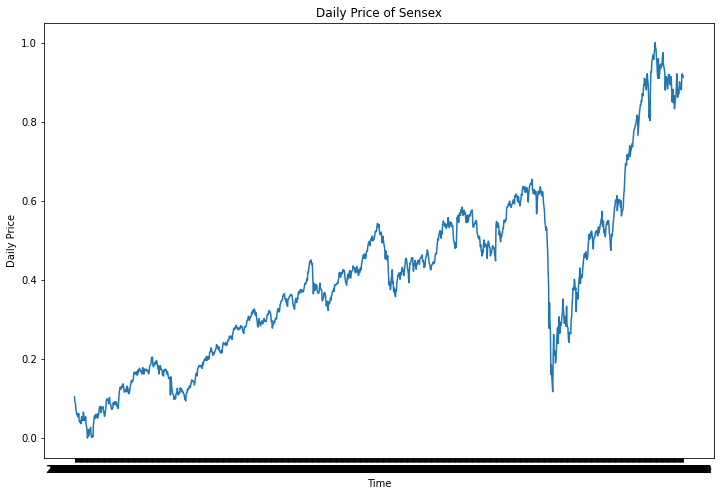

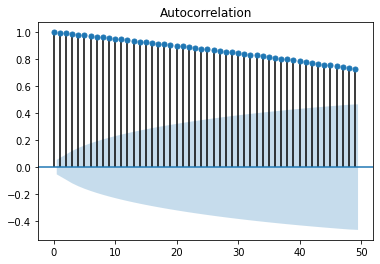

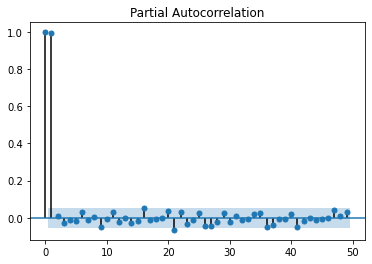

In [ ]:
BTC = pd.read_csv('BSE_Data.csv', sep = ',')
BTC.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Open":scaler.fit_transform(np.array(BTC['Open']).reshape(len(BTC),1)).reshape(len(BTC),)},
                  index = BTC.index)
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Daily Price')
plt.title('Daily Price of Sensex')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

ACF and PACF plots display significant correlation between lags, and hence data is non-stationary. One approach is to take out trend by rolling average and make it stationar for classical analysis.

Manually decomposing trend and seasonality:
 - taking out trend by moving average smoothing method

ADF test results: (-7.80780640688324, 9.004790086644209e-13, 10, 1300, {'1%': -2.5674619923076922, '5%': -1.9412085922972235, '10%': -1.6166172866800181}, -7488.189124476252)
low p-value of ADF test (3.277335734460085e-12) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.
 Hence, we can say that data is trend stationary.


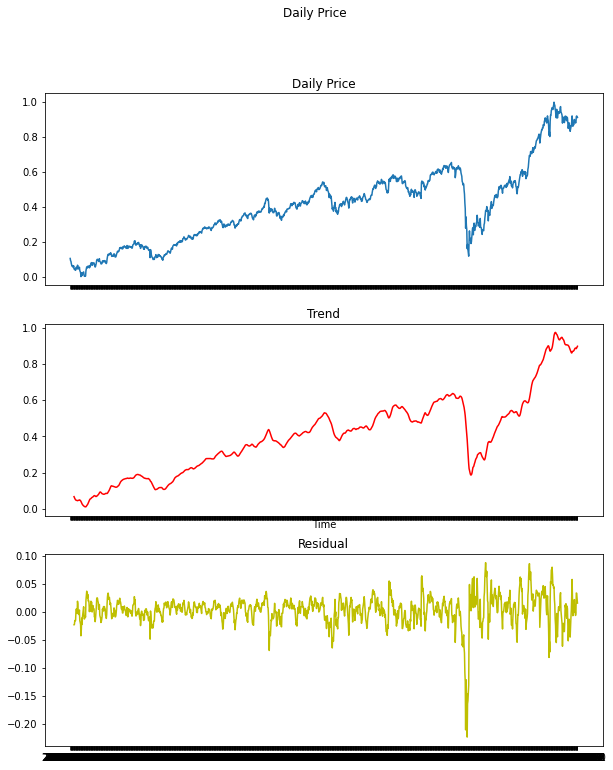

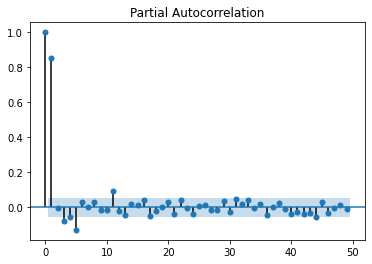

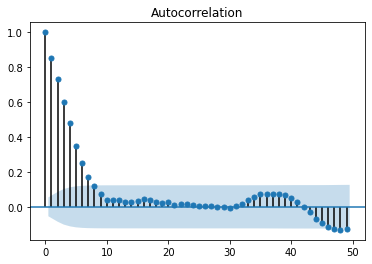

In [ ]:
trendcomp = (df.rolling(10).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
noise = df.iloc[:,0] - trendcomp.iloc[:,0] #- np.array(seasonalcomp).reshape(len(df),)
df['trendcomp'] = trendcomp.values
df['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Daily Price')
fig1, fig2, fig3 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Daily Price')
fig2.set_title('Trend')
fig3.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'Open'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
fig3.plot(df.loc[:,'noise'], 'y')
fig.show()
# taking auto correlations for stationary residual.
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(df.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(df.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.\n Hence, we can say that data is trend stationary.')

As we can see, it is not easy to take out the trend component by rolling average. Another method is to perform differencing on the dataset.

Manually decompose of seasonality and trend: 
    - differencing method to see if time series is difference stationary!

ADF test results: (-10.871160694174854, 1.3357913098839414e-19, 9, 1310, {'1%': -2.5674488310704504, '5%': -1.9412069851207092, '10%': -1.6166188221188553}, -7409.76536344886)
low p-value of ADF test (1.3357913098839414e-19) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


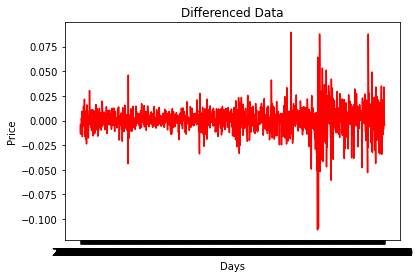

In [ ]:
diff1 = df.loc[:,'Open'].diff(1)
nn = diff1.dropna()
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Price')

# ADF test on difference data:
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

# Train Test Split:

# Time series analysis using deep learning

Preparing data set:

In [ ]:
trainfrac = 0.75
#this function generates the input output
def input_output_generator(z,n):
    #generating input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

Building models and tuning parameters:

In [ ]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'Vanilla LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Unidirectional LSTM':
        model.add(LSTM(nodes[0], activation='relu', kernel_initializer='random_uniform', 
                       bias_initializer='RandomNormal', return_sequences=True, input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(LSTM(nodes[i+1], activation='relu', kernel_initializer='random_uniform', 
                           bias_initializer='RandomNormal',return_sequences=retseq))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                        bias_initializer='RandomNormal'))
    
    if Type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes, activation='relu',
                                     kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    

    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model


def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

# MLP

MLP can be used for univariate time series forecasting. 
The input to the first dense layer has this shape: [n_steps,]. n_steps is the lag of the time series
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
n_samples is the number of samples we feed into depp network.

In [ ]:
lag_mlp = 9 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['Open'].tolist(), lag_mlp)

In [ ]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01, 0.0001]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'Adagrad, rate=0.0001': 0.19822214543819427,
 'Adagrad, rate=0.001': 0.2839292585849762,
 'Adagrad, rate=0.01': 0.06598373502492905,
 'Adam, rate=0.0001': 0.2839292585849762,
 'Adam, rate=0.001': 0.2839292585849762,
 'Adam, rate=0.01': 0.019549790769815445}

In [ ]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.019537610933184624, 1: 0.019536295905709267, 2: 0.019537687301635742}

In [ ]:
nodes_mlp = [200, 100, 50, 1]

In [ ]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [ ]:
batch_size = 30
optimizer = 'Adam'
learning_rate = 0.01

Epoch 1/50
25/25 [==============================] - 1s 16ms/step - loss: 0.0045 - accuracy: 0.0049 - mse: 0.0045 - val_loss: 0.0017 - val_accuracy: 0.0000e+00 - val_mse: 0.0017
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.0049 - mse: 0.0427 - val_loss: 0.0894 - val_accuracy: 0.0000e+00 - val_mse: 0.0894
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0201 - accuracy: 0.0049 - mse: 0.0201 - val_loss: 0.0490 - val_accuracy: 0.0000e+00 - val_mse: 0.0490
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.0049 - mse: 0.0366 - val_loss: 0.0600 - val_accuracy: 0.0000e+00 - val_mse: 0.0600
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.0049 - mse: 0.0297 - val_loss: 0.0513 - val_accuracy: 0.0000e+00 - val_mse: 0.0513
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0309 - accuracy: 0.0049 - mse: 0.0309 - val_l

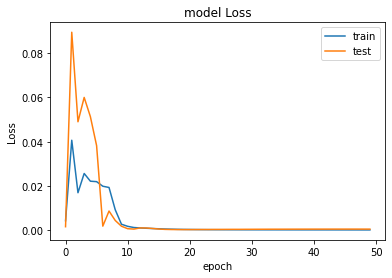

In [ ]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=50,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading Model:

In [ ]:
model_mlp.save('BTC_MLP.h5')
# to load the model:
# model_mlp = load_model('BTC_MLP.h5')

We do one-step ahead recursive forecasting. x_test provides real values to the model for predicting. 

In [ ]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

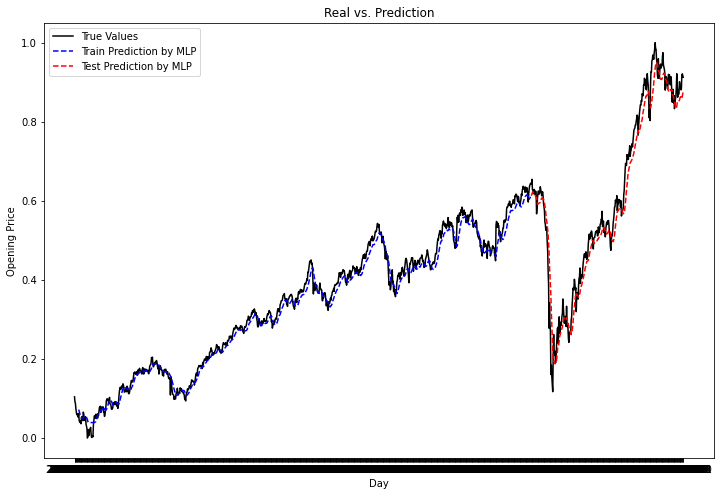

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_mlp, '--b')
plt.plot(testprediction_mlp, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Opening Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by MLP', 'Test Prediction by MLP'], loc='best')
plt.show()

In [ ]:
Metrics = {}
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp)
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp)
Metrics['SMAPE_MLP'] = SMAPE(Y_test_mlp, testprediction_mlp)
Metrics['MSLE_MLP'] = MSLE(Y_test_mlp, testprediction_mlp)
Metrics

{'MAPE_MLP': 52.90924997999309,
 'MSLE_MLP': 0.0008822610628611104,
 'RMSE_MLP': 0.04437938923190163,
 'SMAPE_MLP': 14823.491906611247}

# Vanilla LSTM

LSTM  can be used for univariate and multivariate time series forecasting. 
The input to the first LSTM layer has this shape: [n_steps,n_features]. n_steps is the lag of the time series or
number of lags included for training the model.
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
for multivariate time series it is equal to the number of features.
n_samples is the number of samples we feed into deep network.
All LSTM models can be used in this way.
Remember that The input for LSTMs must be three dimensional. where the thir dimention denotes number of features. the input is in this shape: [n_samples, n_steps, n_features]

In [ ]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [ ]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['Open'].tolist(),
                                                                                   lag_lstm)

In [ ]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Vanilla LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'Adagrad, rate=0.001': 0.06047985702753067,
 'Adagrad, rate=0.01': 0.0024394895881414413,
 'Adagrad, rate=0.1': 0.0004364009655546397,
 'Adam, rate=0.001': 0.00023313499696087092,
 'Adam, rate=0.01': 0.0001629828620934859,
 'Adam, rate=0.1': 0.009458644315600395}

In [ ]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200]
e = Tune_nodes('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [ ]:
#tune batch size
batch = [1, 10, 30]
e = Tune_batch('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [ ]:
nodes = 500
batch_size=20
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('Vanilla LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 500)               1004000   
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
37/37 [==============================] - 4s 49ms/step - loss: 0.0016 - accuracy: 0.0042 - mse: 0.0016 - val_loss: 0.0244 - val_accuracy: 0.0000e+00 - val_mse: 0.0244
Epoch 2/100
37/37 [==============================] - 1s 30ms/step - loss: 0.0100 - accuracy: 0.0042 - mse: 0.0100 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - val_mse: 0.0048
Epoch 3/100
37/37 [==============================] - 1s 30ms/step - loss: 0.0197 - accuracy: 0.0042 - mse: 0.0197 - val_loss: 0.0044 - val_accuracy: 0.0000e+00 - val_mse: 0.0044
Epoch 4/100
37/37 [==============================] - 1s 29ms/step - loss: 0.0325 - accuracy: 0.0042 - mse: 0.0325 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - val_mse: 0.0026
Epoch 5/100
37/37 [==============================] - 1s 29ms/step - loss: 0.0310 - accuracy: 0.0042 - mse: 0.0310 - val_loss: 0.0017 - val_accuracy: 0.0000e+00 - val_mse: 0.0017
Epoch 6/100
37/37 [==============================] - 1s 29ms/step - loss: 0.0317 - accuracy: 0.0042 - mse: 0.0

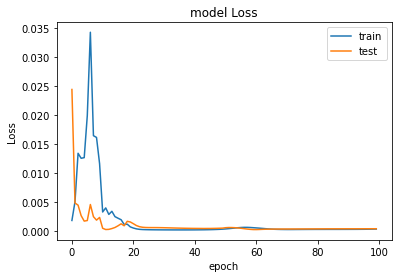

In [ ]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loadin the model:

In [ ]:
model_lstm.save('BTC_LSTM.h5')
# to load the model:
# model_lstm = load_model('BTC_LSTM.h5')

One-step ahead recursive forecasting:

In [ ]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

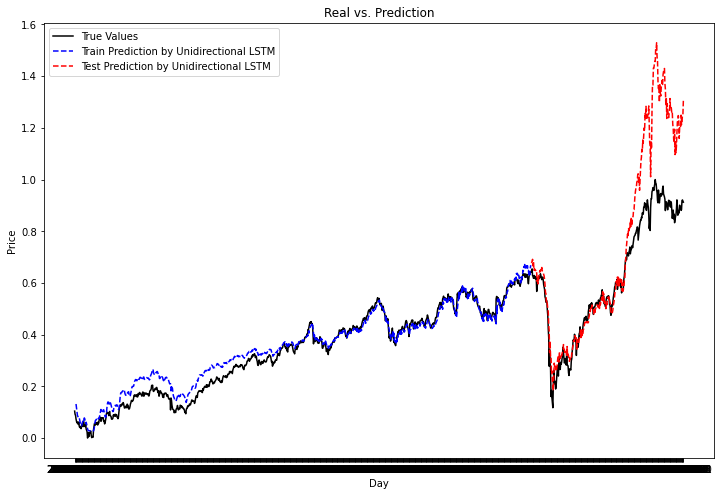

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_lstm, '--b')
plt.plot(testprediction_lstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Unidirectional LSTM', 'Test Prediction by Unidirectional LSTM']
           , loc='best')
plt.show()

In [ ]:
Metrics['RMSE_LSTM'] = RMSE(Y_test_lstm, testprediction_lstm)
Metrics['MAPE_LSTM'] = MAPE(Y_test_lstm, testprediction_lstm)
Metrics['SMAPE_LSTM'] = SMAPE(Y_test_lstm, testprediction_lstm)
Metrics['MSLE_LSTM'] = MSLE(Y_test_lstm, testprediction_lstm)
Metrics

{'MAPE_BL': 56.97777432702609,
 'MAPE_LSTM': 76.04885236982014,
 'MAPE_MLP': 52.90924997999309,
 'MAPE_SUL': 45.14197494798623,
 'MSLE_BL': 0.0006270351479589906,
 'MSLE_LSTM': 0.009830449773439408,
 'MSLE_MLP': 0.0008822610628611104,
 'MSLE_SUL': 0.004637998655192191,
 'RMSE_BL': 0.039808920863436285,
 'RMSE_LSTM': 0.20478296574923105,
 'RMSE_MLP': 0.04437938923190163,
 'RMSE_SUL': 0.11983207085179548,
 'SMAPE_BL': 14786.002656837813,
 'SMAPE_LSTM': 17325.649285955373,
 'SMAPE_MLP': 14823.491906611247,
 'SMAPE_SUL': 13906.639345350066}

# Stacked Unidirectional LSTM

In [ ]:
lag_sul = 3
X_train_sul, Y_train_sul, X_test_sul, Y_test_sul = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_sul)

In [ ]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, [100, 100], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'Adagrad, rate=0.001': 0.28356289863586426,
 'Adagrad, rate=0.01': 0.06513354182243347,
 'Adagrad, rate=0.1': 0.003295872826129198,
 'Adam, rate=0.001': 0.28356289863586426,
 'Adam, rate=0.01': 0.020287014544010162,
 'Adam, rate=0.1': 0.28356289863586426}

In [ ]:
# tuning number of nodes in LSTM layer
nodes = [[10, 10], [50, 50], [100, 100], [400, 400]]
e = Tune_nodes('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{0: 0.28356289863586426,
 1: 0.28356289863586426,
 2: 0.0016618662048131227,
 3: 0.28356289863586426}

In [ ]:
nodes = [100, 100]

In [ ]:
#tune batch size
batch = [10, 30, 50, 100]
e = Tune_batch('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{10: 0.003110880497843027,
 30: 0.28356292843818665,
 50: 0.05928768217563629,
 100: 0.05747552961111069}

Building the model:

In [ ]:
nodes = [100,100]
optimizer = 'Adagrad'
learning_rate = 0.1
batch_size = 10
model_sul = Model_Build('Stacked Unidirectional LSTM', nodes, X_train_sul, optimizer, learning_rate)
model_sul.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_47 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
74/74 [==============================] - 6s 34ms/step - loss: 6.2190e-04 - accuracy: 0.0045 - mse: 6.2190e-04 - val_loss: 0.0126 - val_accuracy: 0.0000e+00 - val_mse: 0.0126
Epoch 2/200
74/74 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.0045 - mse: 0.0210 - val_loss: 0.0123 - val_accuracy: 0.0000e+00 - val_mse: 0.0123
Epoch 3/200
74/74 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.0045 - mse: 0.0276 - val_loss: 0.0133 - val_accuracy: 0.0000e+00 - val_mse: 0.0133
Epoch 4/200
74/74 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.0045 - mse: 0.0310 - val_loss: 0.0148 - val_accuracy: 0.0000e+00 - val_mse: 0.0148
Epoch 5/200
74/74 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.0045 - mse: 0.0329 - val_loss: 0.0165 - val_accuracy: 0.0000e+00 - val_mse: 0.0165
Epoch 6/200
74/74 [==============================] - 0s 6ms/step - loss: 0.0340 - accuracy: 0.0045 - mse: 

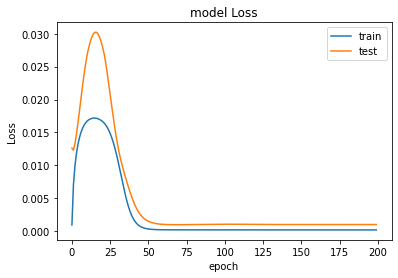

In [ ]:
history_sul = model_sul.fit(X_train_sul, Y_train_sul, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sul.history['loss'])
plt.plot(history_sul.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the Model:

In [ ]:
model_sul.save('BTC_SUL.h5')
# to load the model:
# model_sul = load_model('BTC_SUL.h5')

One-step ahead recursive forecasting:

In [ ]:
trainprediction_sul = model_sul.predict(X_train_sul)
testprediction_sul = model_sul.predict(X_test_sul)
trainprediction_sul = pd.DataFrame(index=df.index[lag_sul:len(df)-len(X_test_sul)], data=trainprediction_sul)
testprediction_sul = pd.DataFrame(index=df.index[len(df)-len(X_test_sul):], data=testprediction_sul)

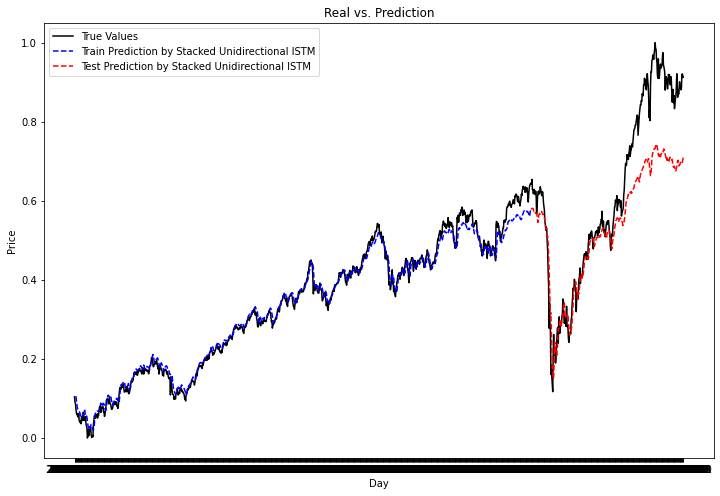

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_sul, '--b')
plt.plot(testprediction_sul, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Stacked Unidirectional lSTM', 'Test Prediction by Stacked Unidirectional lSTM'],
           loc='best')
plt.show()

In [ ]:
Metrics['RMSE_SUL'] = RMSE(Y_test_sul, testprediction_sul)
Metrics['MAPE_SUL'] = MAPE(Y_test_sul, testprediction_sul)
Metrics['SMAPE_SUL'] = SMAPE(Y_test_sul, testprediction_sul)
Metrics['MSLE_SUL'] = MSLE(Y_test_sul, testprediction_sul)
Metrics

{'MAPE_BL': 56.97777432702609,
 'MAPE_MLP': 52.90924997999309,
 'MAPE_SUL': 45.14197494798623,
 'MSLE_BL': 0.0006270351479589906,
 'MSLE_MLP': 0.0008822610628611104,
 'MSLE_SUL': 0.004637998655192191,
 'RMSE_BL': 0.039808920863436285,
 'RMSE_MLP': 0.04437938923190163,
 'RMSE_SUL': 0.11983207085179548,
 'SMAPE_BL': 14786.002656837813,
 'SMAPE_MLP': 14823.491906611247,
 'SMAPE_SUL': 13906.639345350066}

# Bidirectional LSTM

In [ ]:
lag_bl = 3
X_train_bl, Y_train_bl, X_test_bl, Y_test_bl = input_output_generator_LSTM(df['Open'].tolist(), lag_bl)

In [ ]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Bidirectional LSTM', X_train_bl, Y_train_bl, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'Adagrad, rate=0.001': 0.08310378342866898,
 'Adagrad, rate=0.01': 0.006321307737380266,
 'Adagrad, rate=0.1': 0.000637601304333657,
 'Adam, rate=0.001': 0.0006499714218080044,
 'Adam, rate=0.01': 0.00015539606101810932,
 'Adam, rate=0.1': 0.009429732337594032}

In [ ]:
# tuning number of nodes in BLSTM layer
nodes = [50, 100, 200]
e = Tune_nodes('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [ ]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

building the model:

In [ ]:
learning_rate = 0.01
optimizer = 'Adam'
model_bl = Model_Build('Bidirectional LSTM', nodes, X_train_bl, optimizer, learning_rate)
model_bl.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_11 (Bidirectio (None, 100)               81600     
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 101       
Total params: 81,701
Trainable params: 81,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
25/25 [==============================] - 5s 59ms/step - loss: 0.0033 - accuracy: 0.0049 - mse: 0.0033 - val_loss: 0.0065 - val_accuracy: 0.0000e+00 - val_mse: 0.0065
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0370 - accuracy: 0.0049 - mse: 0.0370 - val_loss: 0.0061 - val_accuracy: 0.0000e+00 - val_mse: 0.0061
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.0049 - mse: 0.0524 - val_loss: 0.0237 - val_accuracy: 0.0000e+00 - val_mse: 0.0237
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0164 - accuracy: 0.0049 - mse: 0.0164 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 0.0049 - mse: 0.0119 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - val_mse: 0.0029
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 0.0049 - mse: 0.0037 -

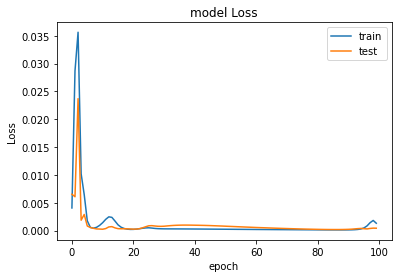

In [ ]:
history_bl = model_bl.fit(X_train_bl, Y_train_bl, validation_split=validation_split, epochs=100, 
                          batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_bl.history['loss'])
plt.plot(history_bl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the model:

In [ ]:
model_bl.save('BTC_BL.h5')
# to load the model:
# model_bl = load_model('BTC_BL.h5')

One-step ahead recursive forecasting:

In [ ]:
trainprediction_bl = model_bl.predict(X_train_bl)
testprediction_bl = model_bl.predict(X_test_bl)
trainprediction_bl = pd.DataFrame(index=df.index[lag_bl:len(df)-len(X_test_bl)], data=trainprediction_bl)
testprediction_bl = pd.DataFrame(index=df.index[len(df)-len(X_test_bl):], data=testprediction_bl)

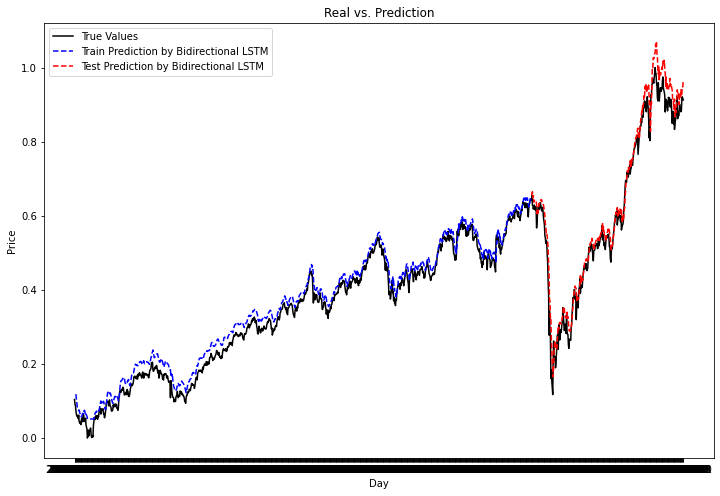

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_bl, '--b')
plt.plot(testprediction_bl, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Bidirectional LSTM', 'Test Prediction by Bidirectional LSTM'],
           loc='best')
plt.show()

In [ ]:
Metrics['RMSE_BL'] = RMSE(Y_test_bl, testprediction_bl)
Metrics['MAPE_BL'] = MAPE(Y_test_bl, testprediction_bl)
Metrics['SMAPE_BL'] = SMAPE(Y_test_bl, testprediction_bl)
Metrics['MSLE_BL'] = MSLE(Y_test_bl, testprediction_bl)
Metrics

{'MAPE_BL': 56.97777432702609,
 'MAPE_MLP': 52.90924997999309,
 'MSLE_BL': 0.0006270351479589906,
 'MSLE_MLP': 0.0008822610628611104,
 'RMSE_BL': 0.039808920863436285,
 'RMSE_MLP': 0.04437938923190163,
 'SMAPE_BL': 14786.002656837813,
 'SMAPE_MLP': 14823.491906611247}